In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def complex_fft2(x):
    """
    x: [B, 2, H, W] => (real, imag) in channels.
    Returns a tensor [B, 2, H, W] with the 2D FFT of x (orthonormal).
    """
    # Separate real and imaginary parts
    real = x[:, 0, :, :]
    imag = x[:, 1, :, :]
    x_complex = torch.complex(real, imag)  # [B, H, W], complex dtype

    # Orthogonal FFT
    X_complex = torch.fft.fft2(x_complex, norm='ortho')

    # Re-split real & imag
    X_real = X_complex.real
    X_imag = X_complex.imag
    return torch.stack([X_real, X_imag], dim=1)  # [B, 2, H, W]

def complex_ifft2(X):
    """
    X: [B, 2, H, W] => (real, imag) in channels.
    Returns a tensor [B, 2, H, W] with the 2D IFFT of X (orthonormal).
    """
    X_real = X[:, 0, :, :]
    X_imag = X[:, 1, :, :]
    X_complex = torch.complex(X_real, X_imag)

    x_complex = torch.fft.ifft2(X_complex, norm='ortho')
    return torch.stack([x_complex.real, x_complex.imag], dim=1)

class DownBlock(nn.Module):
    """
    A typical "down" block in a U-Net:
      - 2x Conv(3x3) + ReLU
      - Then downsample (e.g., MaxPool) unless it's the bottom-most layer
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x_conv = self.conv(x)
        x_down = self.pool(x_conv)
        return x_conv, x_down


class UpBlock(nn.Module):
    """
    An "up" block in a U-Net:
      - Up-sample (could be ConvTranspose2d or bilinear + Conv)
      - Skip connection from the encoder
      - 2x Conv(3x3) + ReLU
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # Transpose convolution for upsampling by factor of 2
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        # After concatenating skip connection, do standard double-conv
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        # Fix shape mismatch (if skip is bigger)
        diffH = skip.size(2) - x.size(2)
        diffW = skip.size(3) - x.size(3)
        if diffH > 0 or diffW > 0:
            # pad (left, right, top, bottom)
            x = F.pad(x, (0, diffW, 0, diffH), mode='constant', value=0)
        x = torch.cat([skip, x], dim=1)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    """
    A more traditional U-Net structure.
    For single-coil MRI + complex data, set in_channels=2, out_channels=2.
    For multi-coil, you might want in_channels=2*num_coils, or feed coil maps differently.
    """
    def __init__(self, 
                 in_channels=2, 
                 out_channels=2, 
                 features=[64, 128, 256, 512]):
        super().__init__()
        self.num_downs = len(features)
        self.down_blocks = nn.ModuleList()
        self.up_blocks = nn.ModuleList()

        # Construct down blocks
        prev_channels = in_channels
        for f in features:
            self.down_blocks.append(DownBlock(prev_channels, f))
            prev_channels = f

        # Construct up blocks (mirror)
        reversed_feats = list(reversed(features))
        for i in range(len(reversed_feats) - 1):
            self.up_blocks.append(UpBlock(reversed_feats[i], reversed_feats[i+1]))

        # Final 1x1 conv
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x, t=None, cond=None):
        """
        If cond is not None, we can concatenate it with x or inject in some other manner.
        For example, if cond has shape [B, cond_channels, H, W], do x=cat([x,cond], dim=1).
        """
        if cond is not None:
            x = torch.cat([x, cond], dim=1)

        # Encoder pathway
        skip_connections = []
        out = x
        for down in self.down_blocks:
            skip, out = down(out)
            skip_connections.append(skip)

        # The bottom of the U is skip_connections[-1] (no more pooling there).
        # But we can rename out to reflect that it is the bottom-most activation
        bottom = skip_connections[-1]

        # Decoder pathway
        # We'll pop from skip_connections from the end
        skip_connections = skip_connections[:-1]  # remove the bottom-most
        up_out = bottom
        for i, up in enumerate(self.up_blocks):
            skip_i = skip_connections[-(i+1)]  # take last skip first
            up_out = up(up_out, skip_i)

        # Final projection
        return self.final_conv(up_out)
        
class DDIM(nn.Module):
    def __init__(
        self,
        unet,
        timesteps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        schedule="linear",
        device='cpu'
    ):
        super(DDIM, self).__init__()
        self.unet = unet.to(device)
        self.timesteps = timesteps
        self.device = device

        # Create betas (noise schedule)
        if schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        elif schedule == "cosine":
            self.betas = self._cosine_beta_schedule(timesteps).to(device)
        else:
            raise ValueError(f"Unknown schedule: {schedule}")

        # Alphas and related quantities
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat(
            [torch.tensor([1.0], device=device), self.alphas_cumprod[:-1]]
        )
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

    def _cosine_beta_schedule(self, timesteps, warmup_frac=0.02):
        warmup_steps = int(timesteps * warmup_frac)
        steps = torch.arange(timesteps + 1, dtype=torch.float64, device=self.device)
        s = 0.008
        alphas_cumprod_full = torch.cos(((steps / timesteps) + s) / (1 + s) * (torch.pi / 2))**2
        alphas_cumprod_full = alphas_cumprod_full / alphas_cumprod_full[0]
        if warmup_steps > 0:
            alpha_end_warmup = alphas_cumprod_full[warmup_steps]
            warmup_range = torch.linspace(1.0, alpha_end_warmup, warmup_steps + 1, device=self.device)
            alphas_cumprod_full[: warmup_steps + 1] = warmup_range
        betas = 1 - (alphas_cumprod_full[1:] / alphas_cumprod_full[:-1])
        return betas.float()

    def forward_diffusion(self, x_start, t):
        """
        Diffuse x_start to x_t by adding noise.
        x_start: [B, 2, H, W], real & imag
        t: [B], time steps
        """
        noise = torch.randn_like(x_start)
        sqrt_alpha = self.sqrt_alphas_cumprod[t][:, None, None, None]
        sqrt_one_minus_alpha = self.sqrt_one_minus_alphas_cumprod[t][:, None, None, None]
        x_t = sqrt_alpha * x_start + sqrt_one_minus_alpha * noise
        return x_t, noise

    def forward(self, x, t, cond=None):
        """
        Training pass. The U-Net predicts noise given x_t at time t (plus optional cond).
        """
        return self.unet(x, t, cond=cond)

    ### --- Improved K-space Data Consistency --- ###
    def enforce_data_consistency(self, x_pred, x_measured_k, mask):
        """
        Enforce that the predicted image has the same k-space values
        where data is known (mask=1). Single-coil example.

        Args:
          x_pred: [B, 2, H, W] image domain (real, imag)
          x_measured_k: [B, 2, H, W] measured k-space data (real, imag)
          mask: [B, 1, H, W] or [B, 2, H, W] where 1 indicates known k-space entries
                (if shape is [B,1,H,W], we’ll broadcast to match [B,2,H,W])

        Returns:
          new_x_pred: the updated image after substituting known k-space lines.
        """
        # 1) Transform predicted image to frequency domain
        X_pred_k = complex_fft2(x_pred)  # [B, 2, H, W]

        # 2) Merge with measured data in the known region
        #    Expand mask to 2 channels if necessary
        if mask.shape[1] == 1:
            mask = mask.repeat(1, 2, 1, 1)  # now [B,2,H,W]

        X_updated = X_pred_k * (1 - mask) + x_measured_k * mask

        # 3) Go back to image domain
        x_updated = complex_ifft2(X_updated)
        return x_updated

    def reverse_diffusion(self, x_t, t, x_measured_k=None, mask=None, eta=0):
        """
        Single step of reverse diffusion. Optionally enforce data consistency in k-space.

        x_t: [B, 2, H, W], the noisy image at time t.
        x_measured_k: [B, 2, H, W], the measured k-space data (optional).
        mask: [B, 2, H, W] or [B, 1, H, W], indicates known k-space lines (1=> known).
        eta: noise level for DDIM sampling.
        """
        cond = None
        if (x_measured_k is not None) and (mask is not None):
            # In advanced usage, you might feed the measured data or mask as additional channels
            # to the U-Net. For now, we just do a direct call:
            cond = None  # or torch.cat([some_image, mask], dim=1)

        # 1) Predict noise using the U-Net
        pred_noise = self.unet(x_t, t, cond=cond)

        alpha = self.alphas[t][:, None, None, None]
        alpha_cumprod = self.alphas_cumprod[t][:, None, None, None]
        alpha_cumprod_prev = self.alphas_cumprod_prev[t][:, None, None, None]

        # 2) Estimate x_0 from x_t
        pred_x0 = (x_t - torch.sqrt(1 - alpha_cumprod) * pred_noise) / torch.sqrt(alpha_cumprod)
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        # 3) Compute the mean for x_{t-1}
        pred_mean = torch.sqrt(alpha_cumprod_prev) * pred_x0 + \
                    torch.sqrt(1 - alpha_cumprod_prev) * pred_noise

        # 4) Add optional stochasticity
        if eta > 0:
            noise = torch.randn_like(x_t)
            sigma = eta * torch.sqrt(self.posterior_variance[t])[:, None, None, None]
            pred_mean = pred_mean + sigma * noise

        # 5) Data consistency in k-space (if we have measured data)
        if (x_measured_k is not None) and (mask is not None):
            pred_mean = self.enforce_data_consistency(
                x_pred=pred_mean, 
                x_measured_k=x_measured_k, 
                mask=mask
            )

        return pred_mean

    def sample(self, shape, x_measured_k=None, mask=None, eta=0):
        """
        Generate samples using reverse diffusion, enforcing k-space consistency if x_measured_k, mask are provided.

        shape: (batch_size, 2, H, W) for single-coil real+imag
        x_measured_k: [B, 2, H, W]
        mask: [B, 1, H, W] or [B, 2, H, W], same spatial size, 1 => known data
        eta: additional noise factor for DDIM

        Returns final x_0 in image domain.
        """
        x_t = torch.randn(shape, device=self.device)
        for timestep in reversed(range(self.timesteps)):
            t_tensor = torch.full((shape[0],), timestep, device=self.device, dtype=torch.long)
            x_t = self.reverse_diffusion(
                x_t, t_tensor, x_measured_k=x_measured_k, mask=mask, eta=eta
            )
        return x_t

In [32]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class MRIDataset(Dataset):
    def __init__(self, folder, transform=None):
        """
        Args:
            folder (str): Path to the folder containing the processed .pt files.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.folder = folder
        self.filenames = sorted([f for f in os.listdir(folder) if f.endswith('.pt')])
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filepath = os.path.join(self.folder, self.filenames[idx])
        sample = torch.load(filepath)
        # If the sample has 4 dimensions, we assume its shape is [kx, ky, complex, coil]
        # and we want to convert it to [C, H, W] with C = complex * coil, H = kx, W = ky.
        if sample.ndim == 4:
            # Permute from [kx, ky, complex, coil] to [complex, coil, kx, ky]
            sample = sample.permute(2, 3, 0, 1)
            # Reshape to combine the complex and coil dimensions
            complex_dim, coil_dim, kx, ky = sample.shape
            sample = sample.reshape(complex_dim * coil_dim, kx, ky)
        if self.transform:
            sample = self.transform(sample)
        return sample

def pad_collate_fn(batch, global_max_channels):
    """
    Pads a list of tensors (each of shape [C, H, W]) along the channel, height, 
    and width dimensions so that each sample is padded (or cropped) to:
      - channels: global_max_channels
      - height: max height in the batch
      - width: max width in the batch
    Returns:
        torch.Tensor: Batched tensor of shape [batch_size, global_max_channels, max_H, max_W]
    """
    # Compute max height and width among samples in this batch.
    max_h = max(sample.shape[1] for sample in batch)
    max_w = max(sample.shape[2] for sample in batch)
    
    padded_batch = []
    for sample in batch:
        c, h, w = sample.shape
        # Pad channels: if sample has fewer than global_max_channels, pad; if more, crop.
        if c < global_max_channels:
            pad_c = global_max_channels - c
            sample = F.pad(sample, (0, 0, 0, 0, 0, pad_c))
        elif c > global_max_channels:
            sample = sample[:global_max_channels, :, :]
        # Pad spatial dimensions
        pad_h = max_h - sample.shape[1]
        pad_w = max_w - sample.shape[2]
        padded_sample = F.pad(sample, (0, pad_w, 0, pad_h))
        padded_batch.append(padded_sample)
    
    return torch.stack(padded_batch)


def get_mri_dataloader(data_folder, batch_size=8, shuffle=True, num_workers=0):
    """
    Creates a DataLoader for the processed MRI data.
    
    Args:
        data_folder (str): Path to the folder containing processed .pt files.
        batch_size (int): Batch size.
        shuffle (bool): Whether to shuffle the dataset.
        num_workers (int): Number of worker processes for data loading.
    
    Returns:
        DataLoader: A PyTorch DataLoader ready to be passed to your model.
    """
    dataset = MRIDataset(data_folder)
    global_max_channels = compute_global_max_channels(data_folder)
    # Wrap the collate function to automatically pass global_max_channels.
    collate_fn = lambda batch: pad_collate_fn(batch, global_max_channels)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=num_workers,
                            collate_fn=collate_fn)
    return dataloader


In [178]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

def train_diffusion_model(
    data_folder,
    num_epochs=10,
    lr=1e-4,
    timesteps=1000,
    batch_size=2,
    schedule="linear",
    beta_start=1e-4,
    beta_end=0.02,
    checkpoint_dir=None,
    device = None,
    final_model_path=None,
    loss_function="mse",  # <-- new parameter to specify loss type
    alpha=0.5,                 # used if loss_function == "combined"
    weight_decay=1e-5
):
    """
    Train a diffusion model (DDIM + improved U-Net) on processed MRI data.
    Data is assumed to be .pt files of shape [C, H, W].

    Args:
        data_folder (str): Path to folder containing .pt files (e.g. [coil*2, H, W]).
        num_epochs (int): Number of training epochs.
        lr (float): Learning rate for optimizer.
        timesteps (int): Number of diffusion steps (beta schedule length).
        batch_size (int): Dataloader batch size.
        schedule (str): "linear" or "cosine".
        beta_start (float): Start of beta range for diffusion schedule.
        beta_end (float): End of beta range.
        device (torch.device): If None, will auto-detect CUDA.
        checkpoint_dir (str): Directory to save model checkpoints. If None, checkpoints are not saved.
        final_model_path (str): Where to save the final trained model.
        loss_function (str): "mse" or "l1". Specifies the training loss.
    
    Returns:
        Trained DDIM model.
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Make checkpoint directory if requested
    if checkpoint_dir is not None:
        os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Step 1: Create dataset
    dataset = MRIDataset(data_folder)
    
    # Now the expected shape is: [kx, ky, 2, coil]
    sample = dataset[0]
    num_coils = sample.shape[-1]  # The last dimension represents coils
    print(f"Detected number of coils (first sample): {num_coils}")
    print("Sample shape:", sample.shape)
    
    # Step 2: Compute max number of channels across all .pt files, if needed
    global_max_channels = compute_global_max_channels(data_folder)
    
    # Step 3: Train/val split at 70:25 ratio, ignoring leftover 5% if any
    total_len = len(dataset)
    train_size = int(0.75 * total_len)
    val_size = int(0.15 * total_len)
    leftover_size = total_len - (train_size + val_size) # 0.15
    train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, leftover_size])
    
    print(f"Dataset split: {train_size} train, {val_size} val, {leftover_size} test.")
    
    # We define a custom collate_fn (for padding, if needed)...
    def collate_fn(batch):
        return pad_collate_fn(batch, global_max_channels)
    
    # Step 4: Dataloaders
    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn
    )
    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn
        )
    test_loader = DataLoader(
        test_ds,
        batch_size=batch_size,
        shuffle=True,
        pin_memory=True,
        collate_fn=collate_fn
        )

    # Step 5: Build the U-Net (or improved U-Net if you changed it)
    unet = UNet(
        in_channels=global_max_channels,    # input channels (max channels across dataset)
        out_channels=global_max_channels,   # output channels  
        features=[64, 128, 256],            # can be adjusted as needed
    ).to(device)

    # Step 6: Build the DDIM
    ddim = DDIM(
        unet=unet,
        timesteps=timesteps,
        beta_start=beta_start,
        beta_end=beta_end,
        schedule=schedule,
        device=device
    )
    
    mse_criterion = nn.MSELoss()
    l1_criterion = nn.L1Loss()

    def combined_loss(pred, target, alpha=alpha):
        return alpha * l1_criterion(pred, target) + (1 - alpha) * mse_criterion(pred, target)

    if loss_function.lower() == "mse":
        criterion = mse_criterion
        print("Using MSELoss for training.")
    elif loss_function.lower() == "l1":
        criterion = l1_criterion
        print("Using L1Loss for training.")
    elif loss_function.lower() == "combined":
        criterion = lambda p, t: combined_loss(p, t, alpha=alpha)
        print(f"Using combined L1 + MSE loss (alpha={alpha}).")
    else:
        raise ValueError(f"Unknown loss_function: {loss_function}. Please use 'mse', 'l1', or 'combined'.")

    # Step 8: Create optimizer
    optimizer = optim.Adam(ddim.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    # Step 9: Training loop
    for epoch in range(num_epochs):
        ddim.train()
        train_loss_sum = 0.0

        # -- Train --
        for batch in tqdm(train_loader, desc=f"[Train] Epoch {epoch+1}/{num_epochs}"):
            batch = batch.to(device)  # shape: (B, C, H, W)

            # Sample random timesteps for each batch element
            t = torch.randint(0, timesteps, (batch.size(0),), device=device).long()

            # Forward diffusion: get the noised version and the ground-truth noise
            x_t, noise = ddim.forward_diffusion(batch, t)

            # No specific conditioning for now
            cond = None

            # Predict the noise
            pred_noise = ddim(x_t, t, cond=cond)

            # Loss against the true noise
            loss = criterion(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()

        avg_train_loss = train_loss_sum / len(train_loader)

        # -- Validate --
        ddim.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"[Val]   Epoch {epoch+1}/{num_epochs}"):
                batch = batch.to(device)

                t = torch.randint(0, timesteps, (batch.size(0),), device=device).long()
                x_t, noise = ddim.forward_diffusion(batch, t)
                cond = None

                pred_noise = ddim(x_t, t, cond=cond)
                val_loss = criterion(pred_noise, noise)
                val_loss_sum += val_loss.item()

        avg_val_loss = val_loss_sum / len(val_loader)

        # Print epoch summary
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

        # Save checkpoint
        if checkpoint_dir is not None:
            checkpoint_path = os.path.join(checkpoint_dir, f"ddim_epoch_{epoch+1}.pt")
            torch.save(ddim.state_dict(), checkpoint_path)
            print(f"Saved checkpoint: {checkpoint_path}")

    # Save final model if requested
    if final_model_path is not None:
        torch.save(ddim.state_dict(), final_model_path)
        print(f"Final model saved at: {final_model_path}")

    print("Training complete!")
    return ddim


In [181]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/new2_1_model.pt"

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder,
        num_epochs=15,
        lr=1e-3,
        timesteps=1000,
        batch_size=8,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.02,
        checkpoint_dir=checkpoint_directory,
        device = None, 
        final_model_path=final_model_path,
        loss_function="combined"
    )

Using device: cuda
Detected number of coils (first sample): 208
Sample shape: torch.Size([30, 512, 208])
Dataset split: 4581 train, 916 val, 612 test.
Using combined L1 + MSE loss (alpha=0.5).


[Val]   Epoch 1/15: 100%|██████████| 115/115 [10:36<00:00,  5.54s/it]


Epoch [1/15] | Train Loss: 0.769323 | Val Loss: 0.711237
Saved checkpoint: checkpoints/ddim_epoch_1.pt


[Val]   Epoch 2/15: 100%|██████████| 115/115 [09:49<00:00,  5.12s/it]


Epoch [2/15] | Train Loss: 0.685229 | Val Loss: 0.661577
Saved checkpoint: checkpoints/ddim_epoch_2.pt


[Val]   Epoch 3/15: 100%|██████████| 115/115 [10:44<00:00,  5.60s/it]


Epoch [3/15] | Train Loss: 0.656269 | Val Loss: 0.661913
Saved checkpoint: checkpoints/ddim_epoch_3.pt


[Val]   Epoch 4/15: 100%|██████████| 115/115 [10:47<00:00,  5.63s/it]


Epoch [4/15] | Train Loss: 0.638085 | Val Loss: 0.650171
Saved checkpoint: checkpoints/ddim_epoch_4.pt


[Val]   Epoch 5/15: 100%|██████████| 115/115 [10:42<00:00,  5.59s/it]


Epoch [5/15] | Train Loss: 0.627081 | Val Loss: 0.627023
Saved checkpoint: checkpoints/ddim_epoch_5.pt


[Val]   Epoch 6/15: 100%|██████████| 115/115 [10:29<00:00,  5.47s/it]


Epoch [6/15] | Train Loss: 0.612548 | Val Loss: 0.604439
Saved checkpoint: checkpoints/ddim_epoch_6.pt


[Val]   Epoch 7/15: 100%|██████████| 115/115 [10:39<00:00,  5.56s/it]


Epoch [7/15] | Train Loss: 0.606578 | Val Loss: 0.607647
Saved checkpoint: checkpoints/ddim_epoch_7.pt


[Val]   Epoch 8/15: 100%|██████████| 115/115 [10:53<00:00,  5.68s/it]


Epoch [8/15] | Train Loss: 0.601894 | Val Loss: 0.604733
Saved checkpoint: checkpoints/ddim_epoch_8.pt


[Val]   Epoch 9/15: 100%|██████████| 115/115 [10:31<00:00,  5.49s/it]


Epoch [9/15] | Train Loss: 0.597727 | Val Loss: 0.589088
Saved checkpoint: checkpoints/ddim_epoch_9.pt


[Val]   Epoch 10/15: 100%|██████████| 115/115 [10:36<00:00,  5.53s/it]


Epoch [10/15] | Train Loss: 0.596242 | Val Loss: 0.597401
Saved checkpoint: checkpoints/ddim_epoch_10.pt


[Val]   Epoch 11/15: 100%|██████████| 115/115 [10:49<00:00,  5.65s/it]


Epoch [11/15] | Train Loss: 0.597058 | Val Loss: 0.593158
Saved checkpoint: checkpoints/ddim_epoch_11.pt


[Val]   Epoch 12/15: 100%|██████████| 115/115 [10:40<00:00,  5.57s/it]


Epoch [12/15] | Train Loss: 0.596586 | Val Loss: 0.590493
Saved checkpoint: checkpoints/ddim_epoch_12.pt


[Val]   Epoch 13/15: 100%|██████████| 115/115 [10:51<00:00,  5.66s/it]


Epoch [13/15] | Train Loss: 0.593577 | Val Loss: 0.588730
Saved checkpoint: checkpoints/ddim_epoch_13.pt


[Val]   Epoch 14/15: 100%|██████████| 115/115 [10:17<00:00,  5.37s/it]


Epoch [14/15] | Train Loss: 0.594286 | Val Loss: 0.603357
Saved checkpoint: checkpoints/ddim_epoch_14.pt


[Val]   Epoch 15/15: 100%|██████████| 115/115 [11:08<00:00,  5.81s/it]

Epoch [15/15] | Train Loss: 0.593349 | Val Loss: 0.595500
Saved checkpoint: checkpoints/ddim_epoch_15.pt
Final model saved at: models/new2_1_model.pt
Training complete!


In [37]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/new_2_model.pt" # added scheduler

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder,
        num_epochs=20,
        lr=1e-4,
        timesteps=1000,
        batch_size=4,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.02,
        checkpoint_dir=checkpoint_directory,
        device = None, 
        final_model_path=final_model_path,
        loss_function="combined"
    )

Using device: cuda
Detected in_channels (first sample): 30
Sample shape: torch.Size([30, 512, 208])
Dataset split: 4581 train, 1527 val, 1 leftover.
Using combined L1 + MSE loss (alpha=0.5).


[Val]   Epoch 1/20: 100%|██████████| 382/382 [11:18<00:00,  1.78s/it]


Epoch [1/20] | Train Loss: 0.781224 | Val Loss: 0.718035
Saved checkpoint: checkpoints/ddim_epoch_1.pt


[Val]   Epoch 2/20: 100%|██████████| 382/382 [17:24<00:00,  2.74s/it]


Epoch [2/20] | Train Loss: 0.687720 | Val Loss: 0.662581
Saved checkpoint: checkpoints/ddim_epoch_2.pt


[Val]   Epoch 3/20: 100%|██████████| 382/382 [16:29<00:00,  2.59s/it]


Epoch [3/20] | Train Loss: 0.640781 | Val Loss: 0.624581
Saved checkpoint: checkpoints/ddim_epoch_3.pt


[Val]   Epoch 4/20: 100%|██████████| 382/382 [17:26<00:00,  2.74s/it]


Epoch [4/20] | Train Loss: 0.609926 | Val Loss: 0.598426
Saved checkpoint: checkpoints/ddim_epoch_4.pt


[Val]   Epoch 5/20: 100%|██████████| 382/382 [17:30<00:00,  2.75s/it]


Epoch [5/20] | Train Loss: 0.591184 | Val Loss: 0.584774
Saved checkpoint: checkpoints/ddim_epoch_5.pt


[Val]   Epoch 6/20: 100%|██████████| 382/382 [17:20<00:00,  2.72s/it]


Epoch [6/20] | Train Loss: 0.581656 | Val Loss: 0.578323
Saved checkpoint: checkpoints/ddim_epoch_6.pt


[Val]   Epoch 7/20: 100%|██████████| 382/382 [17:55<00:00,  2.82s/it]


Epoch [7/20] | Train Loss: 0.571452 | Val Loss: 0.566236
Saved checkpoint: checkpoints/ddim_epoch_7.pt


[Val]   Epoch 8/20: 100%|██████████| 382/382 [17:44<00:00,  2.79s/it]


Epoch [8/20] | Train Loss: 0.559753 | Val Loss: 0.559766
Saved checkpoint: checkpoints/ddim_epoch_8.pt


[Val]   Epoch 9/20: 100%|██████████| 382/382 [17:45<00:00,  2.79s/it]


Epoch [9/20] | Train Loss: 0.555624 | Val Loss: 0.548442
Saved checkpoint: checkpoints/ddim_epoch_9.pt


[Val]   Epoch 10/20: 100%|██████████| 382/382 [18:09<00:00,  2.85s/it]


Epoch [10/20] | Train Loss: 0.552023 | Val Loss: 0.548621
Saved checkpoint: checkpoints/ddim_epoch_10.pt


[Train] Epoch 11/20: 100%|██████████| 1146/1146 [51:46<00:00,  2.71s/it] 
IOPub message rate exceeded.██▉     | 190/382 [08:45<09:01,  2.82s/it]
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

[Val]   Epoch 15/20: 100%|██████████| 382/382 [13:19<00:00,  2.09s/it]


Epoch [15/20] | Train Loss: 0.538122 | Val Loss: 0.535759
Saved checkpoint: checkpoints/ddim_epoch_15.pt


[Val]   Epoch 16/20: 100%|██████████| 382/382 [17:36<00:00,  2.77s/it]


Epoch [16/20] | Train Loss: 0.538278 | Val Loss: 0.536378
Saved checkpoint: checkpoints/ddim_epoch_16.pt


[Val]   Epoch 17/20: 100%|██████████| 382/382 [13:06<00:00,  2.06s/it]


Epoch [17/20] | Train Loss: 0.533011 | Val Loss: 0.530907
Saved checkpoint: checkpoints/ddim_epoch_17.pt


[Val]   Epoch 18/20: 100%|██████████| 382/382 [17:37<00:00,  2.77s/it]


Epoch [18/20] | Train Loss: 0.529985 | Val Loss: 0.529597
Saved checkpoint: checkpoints/ddim_epoch_18.pt


[Val]   Epoch 19/20: 100%|██████████| 382/382 [17:32<00:00,  2.76s/it]


Epoch [19/20] | Train Loss: 0.529562 | Val Loss: 0.525792
Saved checkpoint: checkpoints/ddim_epoch_19.pt


[Val]   Epoch 20/20: 100%|██████████| 382/382 [17:29<00:00,  2.75s/it]

Epoch [20/20] | Train Loss: 0.527539 | Val Loss: 0.526150
Saved checkpoint: checkpoints/ddim_epoch_20.pt
Final model saved at: models/new_2_model.pt
Training complete!


In [ ]:
if __name__ == "__main__":
    # Path to your folder containing the .pt slice/phase files
    data_folder = "mri-2"

    checkpoint_directory = "checkpoints"
    final_model_path = "models/new_3_model.pt" # added scheduler

    # Train the model with desired hyperparameters
    trained_ddim_model = train_diffusion_model(
        data_folder,
        num_epochs=20,
        lr=1e-4,
        timesteps=1000,
        batch_size=2,
        schedule="cosine",
        beta_start=1e-4,
        beta_end=0.02,
        checkpoint_dir=checkpoint_directory,
        device = None, 
        final_model_path=final_model_path,
        loss_function="l1"
    )

Original sample shape: torch.Size([384, 144, 2, 34])
Reshaped sample shape: torch.Size([68, 384, 144])
After padding, sample shape: torch.Size([76, 384, 144])
torch.Size([38, 384, 144])
torch.Size([1, 384, 144])


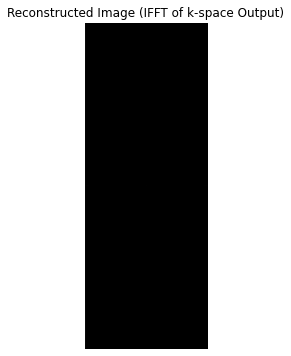

In [99]:
import torch.fft
import matplotlib.pyplot as plt

# --- Load your trained model ---
# Replace these hyperparameters with the ones you used during training.
global_max_channels = 76         # for example, if you have 15 coils (15x2=30)
features = [64, 128, 256]        # example feature sizes
timesteps = 1000                 # diffusion timesteps, etc.
schedule = "cosine"              # or "cosine"
beta_start = 1e-4
beta_end = 0.02

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet = UNet(
    in_channels=global_max_channels,    # input channels should match the global maximum channels
    out_channels=global_max_channels,   # model outputs k-space data with the same channel count
    features=features,
)
ddim = DDIM(
    unet=unet,
    timesteps=timesteps,
    beta_start=beta_start,
    beta_end=beta_end,
    schedule=schedule,
    device=device
)

# Load the saved state dictionary
state_dict = torch.load("models/new_2_model.pt", map_location=device)
ddim.load_state_dict(state_dict)
ddim.to(device)
ddim.eval()

# --- Load a sample input ---
# The sample is expected to be a .pt file with shape [kx, ky, 2, coil]
sample = torch.load("mri-2/us_0058_3T_slice0_phase34.pt", map_location=device)
print("Original sample shape:", sample.shape) 

# Permute to get [2, coil, kx, ky]
sample = sample.permute(2, 3, 0, 1)

sample = sample.reshape(-1, sample.shape[-2], sample.shape[-1])

print("Reshaped sample shape:", sample.shape)

# Pad the sample along the channel dimension if needed.
expected_channels = 76  # global_max_channels used during training
if sample.shape[0] < expected_channels:
    pad_channels = expected_channels - sample.shape[0]
    sample = F.pad(sample, (0, 0, 0, 0, 0, pad_channels))
    print("After padding, sample shape:", sample.shape)
elif sample.shape[0] > expected_channels:
    # Alternatively, crop if the sample has more channels than expected.
    sample = sample[:expected_channels, :, :]
    print("After cropping, sample shape:", sample.shape)

# Add a batch dimension: now [1, C, H, W]
sample = sample.unsqueeze(0).to(device)

# --- Run the model ---
with torch.no_grad():
    t = torch.randint(0, timesteps, (sample.size(0),), device=device).long()
    kspace_output = ddim(sample, t=t, cond=None)
    # Expected kspace_output shape: [B, global_max_channels, H, W]

# --- Convert k-space output to image domain ---
B, C, H, W = kspace_output.shape
if C % 2 != 0:
    raise ValueError("Expected an even number of channels (coil*2).")
num_coils = C // 2

# Reshape to separate coil and complex dimensions: [B, num_coils, 2, H, W]
kspace_reshaped = kspace_output.view(B, num_coils, 2, H, W)
# Convert to a complex tensor: channel 0 is real, channel 1 is imaginary
kspace_complex = torch.complex(kspace_reshaped[:, :, 0, :, :], kspace_reshaped[:, :, 1, :, :])  # [B, num_coils, H, W]
# kspace_complex = torch.fft.fftshift(kspace_complex)

print(kspace_complex[0, :,:,:].shape)

# Apply a 2D inverse FFT to get the image domain data (using orthogonal normalization)
image_coils = torch.fft.ifft2(kspace_complex, dim=(-2, -1),  norm='ortho') # kspace_complex dimension not compatible

# Compute the magnitude of each coil's image
coil_magnitudes = torch.abs(image_coils)
# Combine coils using the Sum-Of-Squares (SOS) method
reconstructed_image = torch.sqrt(torch.sum(coil_magnitudes ** 2, dim=1))  # [B, H, W]
img_min = reconstructed_image.min()
img_max = reconstructed_image.max()
reconstructed_image = (reconstructed_image - img_min) / (img_max - img_min + 1e-8)
# Visualize the first image in the batch
img_to_show = reconstructed_image[0].cpu().numpy()
print(reconstructed_image.shape)

plt.figure(figsize=(6, 6))
plt.imshow(img_to_show, cmap='gray')
plt.title("Reconstructed Image (IFFT of k-space Output)")
plt.axis("off")
plt.show()


In [176]:
import matplotlib.pyplot as plt
import torch
import numpy as np

sample2 = torch.load("mri-2/fs_0001_1_5T_slice0_phase2.pt", map_location=device)
sample3 = torch.load("mri-2/us_0058_3T_slice0_phase34.pt", map_location=device)
# Permute to get [2, coil, kx, ky]
# sample2 = sample2.permute(2, 3, 0, 1)
print(sample2.shape)
print(sample3.shape)

# sample2 = sample2.reshape(-1, sample.shape[-2], sample.shape[-1])
# sample = sample.unsqueeze(0).to(device)

# kspace_complex_sample = torch.complex(kspace_reshaped_sample[:, :, 1, :, :], 
#                                       kspace_reshaped_sample[:, :, 0, :, :])  # [B, num_coils, H, W]

# sample_recon = sample2[0, :, :, :]

# kspace_reshaped_sample = sample_recon.view(B, num_coils, 2, H, W)
# # Convert to a complex tensor: channel 0 is real, channel 1 is imaginary
# kspace_complex_sample = torch.complex(kspace_reshaped_sample[:, :, 1, :, :], 
#                                       kspace_reshaped_sample[:, :, 0, :, :])  # [B, num_coils, H, W]

# image =  torch.fft.ifft2(kspace_complex_sample, dim=(-2, -1),  norm='ortho') 
# coil_magnitudes = torch.abs(image)
# reconstructed_image = torch.sqrt(torch.sum(coil_magnitudes ** 2, dim=1))  

# img_min = reconstructed_image.min()
# img_max = reconstructed_image.max()
# reconstructed_image = (reconstructed_image - img_min) / (img_max - img_min + 1e-8)
# # Visualize the first image in the batch
# img_to_show = reconstructed_image[0,:,:].cpu().numpy()

# print(img_to_show.shape)

# plt.figure(figsize=(6, 6))
# plt.imshow(img_to_show, cmap='gray')
# plt.title("Reconstructed Image (IFFT of k-space Output) of Undersamled image ")
# plt.axis("off")
# plt.show()

torch.Size([30, 512, 208])
torch.Size([384, 144, 2, 34])


Reconstructed image shape: torch.Size([384, 144])


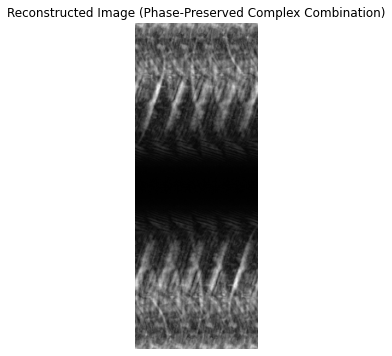

torch.Size([1, 38, 384, 144])
[[0.06517139 0.1564632  0.06991144 ... 0.14486428 0.219672   0.21931069]
 [0.18370993 0.24711762 0.1549265  ... 0.03168272 0.3002562  0.16517042]
 [0.09071805 0.14673075 0.05728951 ... 0.01535084 0.12863222 0.12054478]
 ...
 [0.23145024 0.09034386 0.01860974 ... 0.05222274 0.04558582 0.04587964]
 [0.37712204 0.15079124 0.08623613 ... 0.13542613 0.30857906 0.30076623]
 [0.7682804  0.48130885 0.23433006 ... 0.290173   0.38330868 0.2950826 ]]


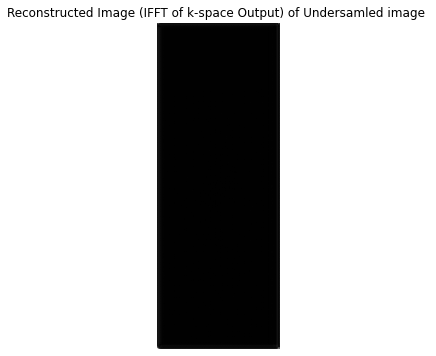

In [167]:
import matplotlib.pyplot as plt
import numpy as np

print(kspace_complex.shape)
img_to_show_r = kspace_complex[0,0,:,:].abs().cpu().numpy()
print(img_to_show_r)
plt.figure(figsize=(6, 6))
plt.imshow(img_to_show_r, cmap='gray')
plt.title("Reconstructed Image (IFFT of k-space Output) of Undersamled image ")
plt.axis("off")
plt.show()

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

def reconstruct_mri_image_no_ifft(
    model_path="models/my_model.pt",
    sample_path="mri-2/my_image_domain_sample.pt",
    global_max_channels=76,   # single coil (real+imag) in this example
    features=[64, 128, 256],
    timesteps=1000,
    schedule="cosine",
    beta_start=1e-4,
    beta_end=0.02,
    device=None
    ):
    """
    Loads a DDIM+UNet model that outputs image-domain data (real+imag).
    Then loads a sample image domain tensor, runs inference, and returns
    the final reconstruction, WITHOUT doing another iFFT.

    Args:
        model_path (str): Path to the trained model checkpoint (.pt).
        sample_path (str): Path to an input .pt file containing [C,H,W] in image domain.
        global_max_channels (int): 2 if single coil (real + imag).
        features (list): U-Net feature channels.
        timesteps (int): Diffusion steps used at training.
        schedule (str): "linear" or "cosine" for beta schedule.
        beta_start, beta_end: Beta range.
        device: torch.device or None.

    Returns:
        final_image (torch.Tensor): [H, W], the magnitude of the final image in [0,1].
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # -------------------------------------------------------------------
    # (A) Instantiate your model the same way as in training
    # -------------------------------------------------------------------
    unet = UNet(
        in_channels=global_max_channels, 
        out_channels=global_max_channels,
        features=features
    )
    ddim = DDIM(
        unet=unet,
        timesteps=timesteps,
        beta_start=beta_start,
        beta_end=beta_end,
        schedule=schedule,
        device=device
    )

    # Load model checkpoint
    print(f"Loading model from: {model_path}")
    state_dict = torch.load(model_path, map_location=device)
    ddim.load_state_dict(state_dict, strict =False)
    ddim.to(device)
    ddim.eval()

    # -------------------------------------------------------------------
    # (B) Load a sample that is ALREADY in the image domain
    # -------------------------------------------------------------------
    # e.g. shape [C,H,W], where C=2 for single coil real+imag
    sample_img = torch.load(sample_path, map_location=device)
    print("Original sample shape:", sample_img.shape)

    # If needed, adjust shape to [B, C, H, W]
    if len(sample_img.shape) == 3:
        sample_img = sample_img.unsqueeze(0)  # add batch dimension
    # If sample_img.shape[1] != global_max_channels, pad/crop as needed
    C = sample_img.shape[1]
    if C < global_max_channels:
        pad_channels = global_max_channels - C
        sample_img = F.pad(sample_img, (0, 0, 0, 0, 0, pad_channels))
    elif C > global_max_channels:
        sample_img = sample_img[:, :global_max_channels, :, :]

    sample_img = sample_img.to(device)
    print("Sample after shape fix:", sample_img.shape)

    # -------------------------------------------------------------------
    # (C) Run the model to get the final image (without iFFT)
    # -------------------------------------------------------------------
    # For training-like forward:
    with torch.no_grad():
        # pick random t for demonstration
        t = torch.randint(0, timesteps, (sample_img.size(0),), device=device).long()
        pred_out = ddim(sample_img, t=t)
        # shape => [B, 2, H, W] if single coil real+imag

    # Now pred_out should be the final "image" in real+imag form
    # (depending on how your model is structured).

    # -------------------------------------------------------------------
    # (D) Convert to magnitude (no additional iFFT!)
    # -------------------------------------------------------------------
    real_part = pred_out[:, 0, :, :]
    imag_part = pred_out[:, 1, :, :]
    magnitude = torch.sqrt(real_part**2 + imag_part**2)  # [B,H,W]

    # Normalize each image in the batch
    mag_min = magnitude.view(magnitude.size(0), -1).min(dim=1)[0].view(-1,1,1)
    mag_max = magnitude.view(magnitude.size(0), -1).max(dim=1)[0].view(-1,1,1)
    eps = 1e-9
    final_image = (magnitude - mag_min) / (mag_max - mag_min + eps)

    return final_image  # shape [B,H,W]

if __name__ == "__main__":
    # Suppose your model is single coil, real+imag in channels=2
    recon_image = reconstruct_mri_image_no_ifft(
        model_path="models/new_2_model.pt",
        sample_path="mri-2/us_0058_3T_slice0_phase34.pt",
        global_max_channels=2,  # single coil real+imag
        features=[64,128,256],
        timesteps=1000,
        schedule="linear"
    )

    print("Reconstructed shape:", recon_image.shape)
    # E.g. => [1,H,W]

    # Plot the first image in the batch
    plt.figure(figsize=(6,6))
    plt.imshow(recon_image[0].cpu().numpy(), cmap='gray')
    plt.title("Reconstructed Image (No iFFT)")
    plt.axis('off')
    plt.show()


Using device: cuda
Loading model from: models/new_2_model.pt


RuntimeError: Error(s) in loading state_dict for DDIM:
	size mismatch for unet.down_blocks.0.conv.0.weight: copying a param with shape torch.Size([64, 76, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 2, 3, 3]).
	size mismatch for unet.final_conv.weight: copying a param with shape torch.Size([76, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 64, 1, 1]).
	size mismatch for unet.final_conv.bias: copying a param with shape torch.Size([76]) from checkpoint, the shape in current model is torch.Size([2]).